In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dropout,Dense,Embedding,LSTM
from keras.layers.merge import add
import collections

Using TensorFlow backend.


In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile('./Downloads/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
captions = captions.split('\n')[:-1]

In [4]:
print(len(captions))

40460


In [5]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

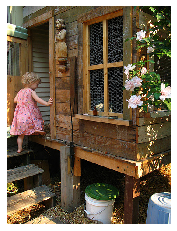

In [7]:
IMG_PATH = "./Downloads/flickr8k/Flickr_Data/Flickr_Data/Images/"
import cv2
img = cv2.imread(IMG_PATH+ "1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    #print(sentence)
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

In [9]:
clean_text("A little girl climbing the stairs to her playhouse #.")

'little girl climbing the stairs to her playhouse'

In [10]:
#cleaning all the captions.
for key,caption_list in descriptions.items():
    for i in range (len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [11]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
#writing data to text file
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))

In [13]:
descriptions = None
with open("descriptions_1.txt",'r') as f:
    descriptions = f.read()
    
correct_string = descriptions.replace("'","\"")
descriptions = json.loads(correct_string)

In [14]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print(len(vocab))

8424


In [16]:
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for desc in descriptions[key] for i in desc.split()]

print(len(total_words))

373837


In [17]:
# Gives freq of unique words
counter = collections.Counter(total_words)
freq_cnt = dict(counter)

In [18]:
# filtering to reduce vocab size
sorted_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])
threshold = 10
sorted_cnt = [sf for sf in sorted_cnt if sf[1] > threshold ]
total_words = [x[0] for x in sorted_cnt]

In [19]:
print(len(total_words))

1845


### Preparing test/train data

In [20]:
train_file = readTextFile("./Downloads/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file = readTextFile("./Downloads/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [21]:
train_data = [row.split(".")[0] for row in train_file.split('\n')[:-1]]
test_data = [row.split(".")[0] for row in test_file.split('\n')[:-1]]

In [22]:
train_data[0]

'2513260012_03d33305cf'

In [23]:
train_descriptions = {}
for img_id in train_data:
    train_descriptions[img_id] = []
    for caption in descriptions[img_id]:
        cap_added = "startseq " + caption + " endseq"
        train_descriptions[img_id].append(cap_added)

In [24]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Image preprocessing

In [25]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [26]:
new_model = Model(model.input,model.layers[-2].output)

In [27]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalization of the preprocessed image.
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


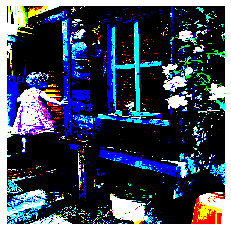

In [28]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [29]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = new_model.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [30]:
encode_img(IMG_PATH+ "1000268201_693b08cb0e.jpg")

array([0.04154468, 0.1707591 , 0.292768  , ..., 0.05094025, 0.31319624,
       0.86007285], dtype=float32)

In [37]:
# images -->  feature vector encoded from Resnet50 - TRAIN
start = time()
encoding_train = {}
for ix,img_id in enumerate(train_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print("Encoding train progress at %d"%ix)
end = time()
print("Total time taken : ",end-start)

Encoding train progress at 0
Encoding train progress at 100
Encoding train progress at 200
Encoding train progress at 300
Encoding train progress at 400
Encoding train progress at 500
Encoding train progress at 600
Encoding train progress at 700
Encoding train progress at 800
Encoding train progress at 900
Encoding train progress at 1000
Encoding train progress at 1100
Encoding train progress at 1200
Encoding train progress at 1300
Encoding train progress at 1400
Encoding train progress at 1500
Encoding train progress at 1600
Encoding train progress at 1700
Encoding train progress at 1800
Encoding train progress at 1900
Encoding train progress at 2000
Encoding train progress at 2100
Encoding train progress at 2200
Encoding train progress at 2300
Encoding train progress at 2400
Encoding train progress at 2500
Encoding train progress at 2600
Encoding train progress at 2700
Encoding train progress at 2800
Encoding train progress at 2900
Encoding train progress at 3000
Encoding train progr

In [38]:
with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [31]:
infile = open("encoded_train_features.pkl","rb")
encoding_train = pickle.load(infile)
infile.close()

In [62]:
start = time()
encoding_test = {}
for ix,img_id in enumerate(test_data):
    img_path = IMG_PATH + "/"+img_id+".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print("Test Encoding progress at %d"%ix)
end = time()
print("Total time taken : ",end-start)

Test Encoding progress at 0
Test Encoding progress at 100
Test Encoding progress at 200
Test Encoding progress at 300
Test Encoding progress at 400
Test Encoding progress at 500
Test Encoding progress at 600
Test Encoding progress at 700
Test Encoding progress at 800
Test Encoding progress at 900
Total time taken :  299.7547273635864


In [63]:
with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [32]:
infile = open("encoded_test_features.pkl","rb")
encoding_test = pickle.load(infile)
infile.close()

### Captions preprocessing

In [33]:
word2idx = {}
idx2word = {}

for i,word in enumerate(total_words):
    word2idx[word] = i+1       # using 0 index for words that are not present in the feature vector
    idx2word[i+1] = word

In [34]:
#Adding "startseq" and "endseq" to vocab
word2idx["startseq"] = 1846
idx2word[1846] = "startseq"
word2idx["endseq"] = 1847
idx2word[1847] = "endseq"

vocabSize = len(word2idx) + 1
print(vocabSize)

1848


In [35]:
maxLen = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        maxLen = max(maxLen,len(cap.split()))

print(maxLen)

35


In [36]:
with open("word2idx.pkl","wb") as f:
    pickle.dump(word2idx,f)

In [37]:
with open("idx2word.pkl","wb") as f:
    pickle.dump(idx2word,f)

### Data Generator

In [38]:
def data_generator(train_descriptions,encoding_train,word2idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,descList in train_descriptions.items():
            n+=1
            photo = encoding_train[key]
            for cap in descList:
                seq = [word2idx[word] for word in cap.split() if word in word2idx]
                
                for i in range(len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi],maxlen=maxLen,value=0,padding="post")[0]
                    yi = to_categorical([yi],num_classes=vocabSize)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    
                    y.append(yi)
                
                if n == batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n= 0

### Word embedding

In [39]:
f = open("./Downloads/glove6b50dtxt/glove.6B.50d.txt",encoding='utf8')

In [40]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:],dtype="float")
    embedding_index[word] = word_embedding
f.close()

In [41]:
embedding_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [42]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocabSize,emb_dim))
    for word,idx in word2idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
         
    return matrix

In [43]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

### Model Architecture

In [44]:
#images as input
input_image_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_image_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [45]:
#captions as input
input_captions = Input(shape=(maxLen,))
inp_cap1 = Embedding(input_dim=vocabSize,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [46]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocabSize,activation='softmax')(decoder2)

In [47]:
model = Model(inputs=[input_image_features,input_captions],outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [48]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [49]:
model.compile(loss='categorical_crossentropy',optimizer = "adam")

### Training

In [50]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [51]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word2idx,maxLen,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(1)+'.h5')

In [71]:
train() 

Epoch 1/1
2000/2000 [==============================] - 949s 475ms/step - loss: 3.9421
Epoch 1/1
2000/2000 [==============================] - 847s 424ms/step - loss: 3.2636
Epoch 1/1
2000/2000 [==============================] - 884s 442ms/step - loss: 3.0321
Epoch 1/1
2000/2000 [==============================] - 824s 412ms/step - loss: 2.8940
Epoch 1/1
2000/2000 [==============================] - 820s 410ms/step - loss: 2.7944
Epoch 1/1
2000/2000 [==============================] - 823s 412ms/step - loss: 2.7161
Epoch 1/1
2000/2000 [==============================] - 861s 430ms/step - loss: 2.6559
Epoch 1/1
2000/2000 [==============================] - 874s 437ms/step - loss: 2.6044
Epoch 1/1
2000/2000 [==============================] - 823s 411ms/step - loss: 2.5652
Epoch 1/1
2000/2000 [==============================] - 820s 410ms/step - loss: 2.5302
Epoch 1/1
2000/2000 [==============================] - 817s 408ms/step - loss: 2.4988
Epoch 1/1
2000/2000 [==============================] -

In [52]:
model = load_model("./model_weights/model_1.h5")

### Predicting Output

In [53]:
def predict_captions(testImg):
    input_text = "startseq"
    for i in range(maxLen):
        seq = [word2idx[w] for w in input_text.split() if w in word2idx]
        seq = pad_sequences([seq],maxlen=maxLen,padding='post')
        yPred = model.predict([testImg,seq])
        yPred = yPred.argmax()
        word = idx2word[yPred]
        input_text += (' ' + word)
        if word == 'endseq':
            break
    output_caption = input_text.split()[1:-1]
    output_caption = ' '.join(output_caption)
    
    return output_caption

woman with black and white hat and black hat is standing in front of sports


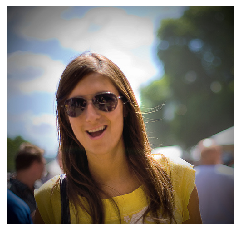

dog with stick in its mouth is in the water


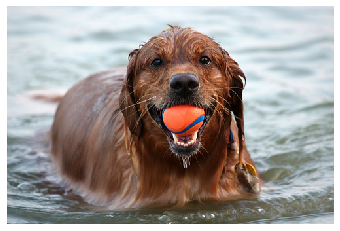

two dogs are playing with toy


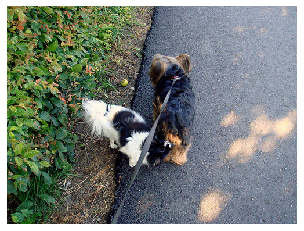

child in red shirt is picking out of the air


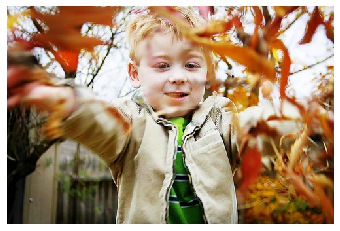

man in blue shirt and tie is standing on the phone while holding cup in his hand


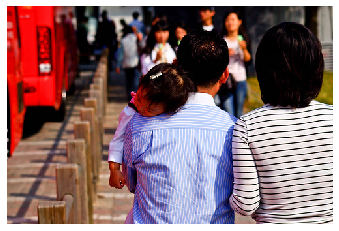

boy in ponytail doing back flip on lawn


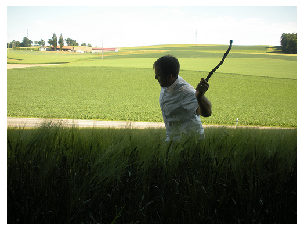

child in red jacket is airborne in the snow


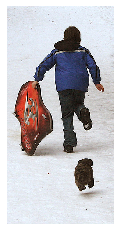

man in black shirt and tie is standing on busy sidewalk


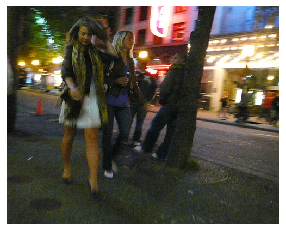

the woman is wearing purple hat and pointing


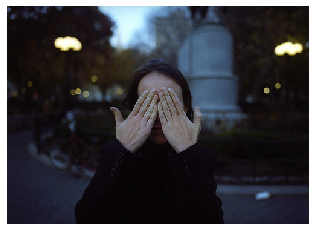

child in red shirt is picking out of the air


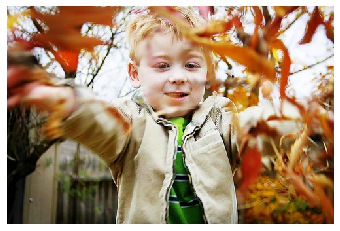

In [54]:
for i in range(10):
    num = np.random.randint(0,1000)
    test_image_list = list(encoding_test.keys())
    test_image_name = test_image_list[num]
    photo = encoding_test[test_image_name].reshape((1,2048))
    
    result = plt.imread(IMG_PATH + "/" + test_image_name +".jpg")
    caption = predict_captions(photo)
    
    plt.axis("off")
    plt.imshow(result)
    print(caption)
    plt.show()